# User Guide

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
d1=pd.read_pickle("../data/sgold.pkl")
d2=pd.read_pickle("../data/cgold.pkl")

In [3]:
import CrossQuantilogram as cq

******


# Lower Level APIs

## 1. Descriptive Statistics

Use `DescriptiveStatistics(data,maxlag)` to calculate the corr between two series. It's source code is in `.utils.py` .
<br>
`maxlag` are the max lag for ADF test.

In [4]:
cq.DescriptiveStatistics(d1["day"],20)

{&#39;mean&#39;: 6.987367579019611e-05,
 &#39;median&#39;: 0.0,
 &#39;min&#39;: -0.07843270189408003,
 &#39;max&#39;: 0.04487175417717548,
 &#39;std&#39;: 0.009584121721712784,
 &#39;skew&#39;: -0.3670340493550927,
 &#39;kurt&#39;: 5.455280842021169,
 &#39;adfs&#39;: -47.20750948402644,
 &#39;adfpv&#39;: 0.0}

`adfs` is the statistics of ADF test. `adfpv` is the P-value of rejecting $H_0$. Here we find the data is stationary.

## 2. Cross-Quantilogram

$$\rho_α(k)=\frac{\mathbf{E}[\psi_{\alpha_1}(x_{1,t}-q_1(\alpha_1))\psi_{\alpha_2}(x_{2,t-k}-q_2(\alpha_2))]}{\sqrt{\psi_{\alpha_1}^2(x_{1,t}-q_1(\alpha_1))}\sqrt{\psi_{\alpha_2}^2(x_{2,t-k}-q_2(\alpha_2))}}$$

Use `CrossQuantilogram(x1,alpha1,x2,alpha2,k)` to calculate the corr coef between two series.<br>
It means the predictability from X2(t-k) to X1(t).

+ Input
    * `x1`: array-like or DataFrame, x1's quantile level.
    * `alpha1`: float between (0,1), quantile of serie-1.
    * `x2`: array-like, x2's quantile level (k lagged).
    * `alpha2`: float between (0,1), quantile of serie-2.
    * `k`: non-negative integer, the serie-2's lag.

+ Output
    * The Cross-Quantilogram statistics, a float number.

In [5]:
cq.CrossQuantilogram(d1["day"],0.1,d2["day"],0.1,1)

0.2971576227390181

`x1` can be n-columns DataFrame. It will return an array.

In [6]:
cq.CrossQuantilogram(d1[["day","intraday","overnight"]],0.1,d2["day"],0.1,1)

array([0.29715762, 0.00258398, 0.34366925])

## 3. Stationary Bootstrap

Use `Bootstrap(x1, x2, lag, bslength, verbose=True)` to generate bootstrapped sample. It's source code is in `.stationarybootstrap.py`

+ Input
    + `x1`: array-like, serie-1, 
    + `x2`: array-like, serie-2, 
    + `lag`: integer, x2's lag, 
    + `bslength`: integer, output length,
    + `verbose`: boolean, 

+ Output
    + A tuple including 2 bootstrapped series x1,x2

In [7]:
cq.Bootstrap(np.arange(100),np.arange(100,200),10,100,verbose=True)

Generating samples:216/100(100%)   


(array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]),
 array([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 1

We usually generate data which has same length as sample data's length.

In [8]:
cq.Bootstrap(d1["day"],d2["day"],20,d1.shape[0],verbose=True)

Generating samples:2464/2151(100%)   


(array([ 0.00187829, -0.01113324,  0.00113787, ..., -0.00832132,
         0.00072635, -0.0091175 ]),
 array([-0.00718032,  0.00553423, -0.0016488 , ...,  0.00955895,
        -0.00523827,  0.00492631]))

The profiling on my i7-8550U laptop:

In [9]:
%timeit cq.Bootstrap(d1["intraday"],d2["day"],20,d1.shape[0],verbose=False)

555 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 4. Hypothesis Tests

$H_0 : \rho_{\alpha}(1)=...=\rho_{\alpha}(k)=0$  
$H_1 : \rho_\alpha(k)\neq0$ for some $k \in \{1,...,p\}$

Use `LjungBoxQ(cqlist,maxp,T)` or `BoxPierceQ(cqlist,maxp,T)` to calculate $Q$ statistics. Use stationary bootstrapped CQ and corresponding $Q$ as a asymptotic distribution to test. 1000 bootstrap repeats are enough.

****

# Higher Level APIs

Here's some frequently used higher-level API. They are contained in `.api.py`

## 1. Cross-Quantilogram with Bootstrap for lags

We can use `CQBS(data1, a1, data2, a2, k, cqcl=0.95, testf=LjungBoxQ, testcl=0.95, n=1000, verbose=True)` to calculate 
CQ at a specific quantile pair $(\alpha_1,\alpha_2)$ for a series of lags $\{k|k \in \mathbb{Z^+\}}$. It can be used for bar plotting.

* Input  
    * `data1`: array-like, serie-1.  
    * `a1`: float between (0,1), quantile of serie-1.  
    * `data2`: array-like, serie-2 (k lagged).
    * `a2`: float between (0,1), quantile of serie-2.
    * `k`: non-negative integer, the serie-2's max lag.
    * `cqcl`: optional float between (0,1), the level of confidence interval of CQ, 0.95 as default.
    * `testf`: optional function, a function calculating the test statistics Q, `qtests.LjungBoxQ` as default.
    * `testcl`: optional float between (0,1), the critical level of Q statistics, 0.95 as default. 
    * `n`: optional integer, the repeating time of bootstrap, 1000 as default.
    * `verbose`: optional boolean, if it will print the procedure.    
* Output
    * pandas.DataFrame containing k rows(k lags) and 5 cols("cq","cq_upper","cq_lower","q","qc")

In [10]:
%%time
cq.CQBS(d1["day"],0.1,d2["day"],0.1,k=10,cqcl=0.95,testcl=0.95,n=1000,verbose=True)

Bootstraping CQ done      
Wall time: 8.32 s


,cq,cq_upper,cq_lower,q,qc
1,0.297158,0.069767,-0.046573,190.204037,7.773190
2,0.018037,0.070382,-0.028018,190.905140,12.428625
3,0.085177,0.101409,-0.000625,206.547145,25.376704
4,0.028273,0.054747,-0.027664,208.271393,27.812262
5,0.002378,0.085082,-0.028636,208.283594,31.600154
6,0.054019,0.060472,-0.027309,214.583764,33.864046
7,0.028122,0.064961,-0.012744,216.292067,36.817826
8,0.012563,0.043582,-0.023626,216.633124,38.151297
9,0.007342,0.100403,0.003219,216.749654,48.021069
10,0.018743,0.077212,-0.002025,217.509499,53.762169


## 2. Cross-Quantilogram with Bootstrap for alphas

We can use `CQBS_alphas(data1, a1list, data2, a2list, k=1, cqcl=0.95, testf=LjungBoxQ, testcl=0.95, all=False, n=1000,verbose=True)` to calculate CQ at a certain lag $k$ for a series of quantile pairs $\{(\alpha_1,\alpha_2)|\alpha_1,\alpha_2 \in (0,1)\}$. It will return a 2D list, which can be used for heatmap.

Return a 2D list of DataFrame(if all=True) or a 2D list of dict(if all=False). Shape:$[row(data2),col(data1)]$ <br>
It's slow beacuse of calling `CQBS()` for $len(a1list)×len(a2list)$ times.
* Input:
    * `data1`: array-like, serie_1.
    * `a1list`: array-like and between (0,1), quantiles of serie_1.
    * `data2`: array-like, serie_2 (k lagged).
    * `a2list`: array-like and between (0,1), quantiles of serie_2.
    * `k`: optional non-negative integer, the serie_2's max lag, 1 as default.
    * `cqcl`: optional float between (0,1), the level of confidence interval of CQ, 0.95 as default.
    * `testf`: optional function, a function calculating the test statistics Q, `qtests.LjungBoxQ` as default.
    * `testcl`: optional float between (0,1), the critical level of Q statistics, 0.95 as default.
    * `all`: optional boolean, True if you want to save all [1,k] results so the 2D list will contain DataFrame;        False if you want to save the last result (only for lag k) so the 2D list will contain dict, False as default.
    * `n`: optional integer, the repeating time of bootstrap, 1000 as default.
    * `verbose`: optional boolean, if it will print the procedure.
* Output:
    * 2D list, rows(1D) for data2, cols(2D) for data1, items are dicts or DataFrame(return of `CQBS`)


In [11]:
%%time
alist=[0.1,0.5,0.9]
cq.CQBS_alphas(d1["day"],alist,d2["day"],alist,k=1,cqcl=0.95,testcl=0.95,all=False,n=1000,verbose=True)

Bootstraping CQ done      
Wall time: 7.73 s


array([[{&#39;cq&#39;: 0.2971576227390181, &#39;cq_upper&#39;: 0.07042998021070436, &#39;cq_lower&#39;: -0.04909560723514211, &#39;q&#39;: 190.2040372406063, &#39;qc&#39;: 7.77318984693616},
        {&#39;cq&#39;: 0.15007751937984495, &#39;cq_upper&#39;: 0.02143971456414087, &#39;cq_lower&#39;: -0.06635658914728682, &#39;q&#39;: 48.515137394996664, &#39;qc&#39;: 7.350239588439365},
        {&#39;cq&#39;: 0.06976744186046513, &#39;cq_upper&#39;: -0.01808785529715763, &#39;cq_lower&#39;: -0.10668070531915509, &#39;q&#39;: 10.484593054699591, &#39;qc&#39;: 21.87675780919648}],
       [{&#39;cq&#39;: 0.1937984496124031, &#39;cq_upper&#39;: 0.027964845083662017, &#39;cq_lower&#39;: -0.04039366512084513, &#39;q&#39;: 80.89963776774373, &#39;qc&#39;: 2.7389381362647325},
        {&#39;cq&#39;: 0.20651162790697675, &#39;cq_upper&#39;: 0.008372093023255815, &#39;cq_lower&#39;: -0.06511627906976744, &#39;q&#39;: 91.86181050805591, &#39;qc&#39;: 7.634647671475468},
        {&#39;cq&#39;: 0.168992

## 3. Cross-Quantilogram with Bootstrap for each year

We can use `CQBS_years(data1, a1, data2, a2, k=1, window=1, cqcl=0.95, testf=LjungBoxQ, testcl=0.95, all=False, n=1000,verbose=True)` to calculate annual CQ at a certain $(\alpha_1,\alpha_2)$ and a certain lag $k$ for different years. It will return a list which can be used for rolling line plotting.

Return 1 DataFrame(if all=False) or a list of DataFrame(if all=True) at $lag∈[1,k]$.<br>
It's slow beacuse of calling `CQBS()` for $\#years$ times.
* Input:
    * `data1`: array-like, serie_1.
    * `a1`: float between (0,1), quantile of serie_1.
    * `data2`: array-like, serie_2 (k lagged).
    * `a2`: float between (0,1), quantile of serie_2.
    * `k`: optional non-negative integer, the serie_2's max lag, 1 as default.
    * `window`: optional positive integer, the rolling window (years), 1 as default.
    * `cqcl`: optional float between (0,1), the level of confidence interval of CQ, 0.95 as default.
    * `testf`: optional function, a function calculating the test statistics Q, `qtests.LjungBoxQ` as default.
    * `testcl`: optional float between (0,1), the critical level of Q statistics, 0.95 as default.
    * `all`: optional boolean, True if you want to save all [1,k] results so the list will contain k DataFrame, 
        False if you want to save the last result (only for lag k) so it will return 1 DataFrame, False as default.
    * `n`: optional integer, the repeating time of bootstrap, 1000 as default.
    * `verbose`: optional boolean, if it will print the procedure.
* Output:
    * pandas.DataFrame(return of CQ_lags) or a list of pandas.DataFrame(if all=True).


In [12]:
%%time
cq.CQBS_years(d1["day"],0.1,d2["day"],0.1,k=1,window=1,cqcl=0.95,testcl=0.95,all=False,n=1000,verbose=True)

Bootstraping CQ done      
Wall time: 7.13 s


,cq,cq_upper,cq_lower,q,qc
2010,0.613713,0.089136,-0.107850,88.516201,2.446054
2011,0.582367,0.164733,-0.020882,81.061381,3.753596
2012,0.535747,-0.012536,-0.114206,68.315708,3.104411
2013,0.130014,0.226680,-0.010352,3.938800,8.133238
2014,0.025974,0.084841,-0.113173,0.161925,3.074089
2015,-0.020882,0.030738,-0.113689,0.104220,3.089290
2016,0.071926,-0.067285,-0.113689,1.236488,3.089290
2017,0.072356,0.118738,-0.107900,1.256568,2.798472
2018,0.118329,0.118329,-0.111131,3.346624,3.346624
2019,-0.126761,0.154930,-0.126761,0.628039,0.938181


# Plotting Scripts

We provide 3 typical kinds of plotting for researches. You can find source code in `.plot.py`

## 1. Bar plot with CQBS()

```python
def bar_example(data1,data2,picname="",show=True):
    alist=[0.1,0.5,0.9]
    dataset=[CQBS(data1,alist[i],data2,alist[i],20,verbose=True) for i in range(3)]

    fig1,ax1=plt.subplots(2,3,figsize=(12,4))
    plt.subplots_adjust(wspace=0.3,hspace=0.8) 
    xaxis=[str(x) for x in dataset[0].index]    
    ax1[0][0].set_ylabel("Cross-Quantilogram",fontsize="x-large",labelpad=0.1)

    for i in range(3):
        ax1[0][i].set_title("α={}".format(alist[i]),fontsize="xx-large")       
        ax1[0][i].tick_params(labelsize="large")
        ax1[0][i].axhline(color="black",linewidth=1)
        ax1[0][i].bar(xaxis,dataset[i]["cq"],width=0.2,color="black")
        ax1[0][i].plot(xaxis,dataset[i]["cq_upper"],color='red',linestyle="dashed")
        ax1[0][i].plot(xaxis,dataset[i]["cq_lower"],color='red',linestyle="dashed")
        ax1[0][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        m = (abs(dataset[i]["cq"]).max()//0.05)*0.05+0.1
        ax1[0][i].set_ylim(-m,m)
        
    ax1[1][0].set_ylabel("Portmanteau",fontsize="x-large")
    for i in range(3):
        ax1[1][i].set_title("α={}".format(alist[i]),fontsize="xx-large")
        ax1[1][i].set_xlabel("lag",fontsize="xx-large")        
        ax1[1][i].tick_params(labelsize="large")
        ax1[1][i].plot(xaxis,dataset[i]["q"],color='black')
        ax1[1][i].plot(xaxis,dataset[i]["qc"],color='red',linestyle="dotted")
        ax1[1][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    fig1.align_labels()
    if picname:
        fig1.savefig(picname+".png",dpi=200,quality=95,bbox_inches="tight")   
    if show:
        print(str(picname)+":")
        plt.show()m
```

Bootstraping CQ done      
Bootstraping CQ done      
Bootstraping CQ done      
:


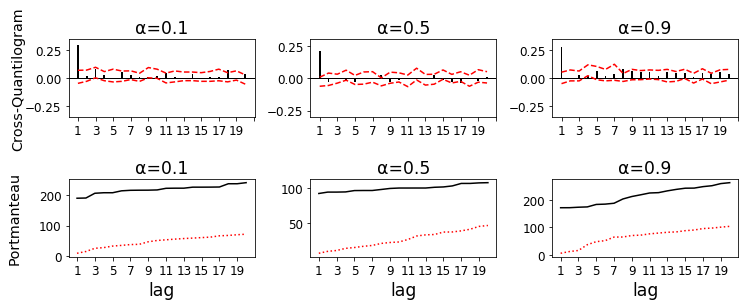

Wall time: 52.2 s


In [13]:
%%time
cq.bar_example(d1["day"],d2["day"])

The figures in the first row show the CQ results at $\alpha_1=\alpha_2=\{0.1,0.5,0.5\}$ for $k \in \{1,...,20\}$. Black bars are C; Red dashed lines are 95% confidence interval generated by 1000 times stationary bootstraps.  
  
The figures in the second row show the correspongding Portmenteau(LjungBox) Q Statistics at $\alpha_1=\alpha_2=\{0.1,0.5,0.5\}$ for $k \in \{1,...,20\}$. Black lines are Q; Red dashed lines are 95% critical value generated by 1000 times stationary bootstraps.

## 2. Heatmap plot with CQBS_alphas()

```python
def heatmap_example(data1,data2,picname="",show=True):
    alist=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    dataset = CQBS_alphas(data1,alist,data2,alist,1,verbose=True)
    data_mat=np.array([[d["cq"] for d in row] for row in dataset])
    data_txt=[["*" if ((d["cq"]>d["cq_upper"] or d["cq"]<d["cq_lower"])and d["q"]>d["qc"])\
                else "" for d in row] for row in dataset]
                
    fig, ax = plt.subplots(figsize=(4,5))
    im = ax.imshow(data_mat, cmap="Greys")
    ax.set_ylabel("US lag=1",fontsize="xx-large",verticalalignment="center",labelpad=5)
    ax.set_xlabel("CN",fontsize="xx-large",labelpad=35)
    cbar = ax.figure.colorbar(im,ax=ax,fraction=0.046,pad=0.02,orientation="horizontal",)
    cbar.ax.tick_params(labelsize="large")
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    ax.set_xticks(np.arange(data_mat.shape[1]))
    ax.set_yticks(np.arange(data_mat.shape[0]))
    ax.set_yticklabels(alist,horizontalalignment="right",fontsize="large")
    ax.set_xticklabels(alist,fontsize="large")    
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)                   
    plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",rotation_mode="anchor")        
    ax.set_xticks(np.arange(data_mat.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data_mat.shape[0]+1)-.5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    data = im.get_array()
    valfmt="{x}"
    threshold = im.norm(data.max())/2.0
    textcolors=["black", "white"]
    kw = dict(horizontalalignment="center",verticalalignment="center")              
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data_txt[i][j], None),fontsize="large",**kw)

    fig.tight_layout()
    if picname:
        fig.savefig(picname+".png",dpi=200,quality=95,bbox_inches="tight")
    if show:
        print(picname+":")
        plt.show()
```

Bootstraping CQ done      
:


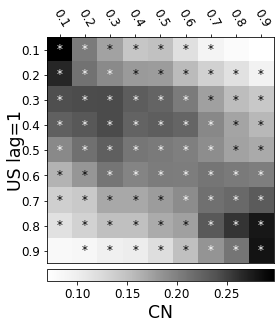

Wall time: 1min 16s


In [14]:
%%time
cq.heatmap_example(d1["day"],d2["day"])

The heatmap shows the CQ at $\{(\alpha_{cn},\alpha_{us})|(\alpha_{cn},\alpha_{us})\in0.1,...,0.9\}$ and $k=1$. It represents the spillover from US market at day t towards CN market at day t+1. The star mark in each scenario means the significance in CQ and Q test.

## 3. Line plot with CQBS_years()

```Python
def rolling_example(data1,data2,picname="",show=True):
    alist=[0.1,0.5,0.9]
    dataset = [CQBS_years(data1,alist[i],data2,alist[i],verbose=True) for i in range(3)]
    fig1,ax1=plt.subplots(2,3,figsize=(12,6))
    plt.subplots_adjust(wspace=0.3,hspace=0.5) 
    xaxis=[x for x in dataset[0].index]
    
    ax1[0][0].set_ylabel("Rolling\nCross-Quantilogram",fontsize="x-large",labelpad=0.1)
    for i in range(3):
        ax1[0][i].set_title("α={}".format(alist[i]),fontsize="xx-large")     
        ax1[0][i].tick_params(labelsize="large")
        ax1[0][i].axhline(color="black",linewidth=1)        
        ax1[0][i].plot(xaxis,dataset[i]["cq_upper"],"rd--",markersize=5,markerfacecolor="w")
        ax1[0][i].plot(xaxis,dataset[i]["cq_lower"],"rd--",markersize=5,markerfacecolor="w")
        ax1[0][i].plot(xaxis,dataset[i]["cq"],"ko-",markersize=4)
        ax1[0][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        m = (max(abs(dataset[i]["cq"]).max(),abs(dataset[i]["cq_upper"]).max(),abs(dataset[i]["cq_lower"]).max())//0.05)*0.05+0.1
        ax1[0][i].set_ylim(-m,m)
        
    ax1[1][0].set_ylabel("Portmanteau",fontsize="x-large")
    for i in range(3):
        ax1[1][i].set_title("α={}".format(alist[i]),fontsize="xx-large")
        ax1[1][i].set_xlabel("year",fontsize="xx-large")        
        ax1[1][i].tick_params(labelsize="large")
        ax1[1][i].plot(xaxis,dataset[i]["q"],color='black')
        ax1[1][i].plot(xaxis,dataset[i]["qc"],color='red',linestyle="dotted")
        ax1[1][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    fig1.align_labels()

    if picname:
        fig1.savefig(picname+".png",dpi=200,quality=95,bbox_inches="tight")   
    if show:
        print(picname+":")
        plt.show()
```

Bootstraping CQ done      
Bootstraping CQ done      
Bootstraping CQ done      
:


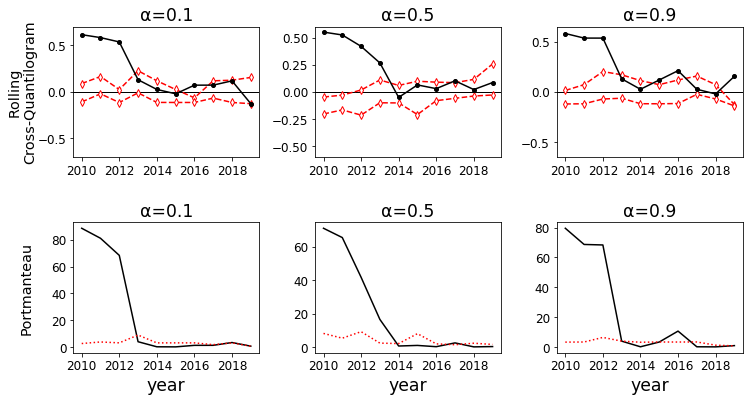

Wall time: 25.8 s


In [15]:
%%time
cq.rolling_example(d1["day"],d2["day"])

The line figures show the the CQ and Portmenteau Q results at $\alpha_1=\alpha_2=\{0.1,0.5,0.5\}$ and $k=1$ for $year=\{2010,...,2019\}$